In [8]:
%matplotlib inline

Reproduce Natural Image Experiments using DQN
=====================================

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import matplotlib.pyplot as plt

from distributions import Categorical, DiagGaussian
from collections import namedtuple

import img_env 

import utils

import model

from PIL import Image

from random import randint
import numpy as np


Build the model
-------------
I keep almost the same architecture as the original code (model.py), except:
* I expose Q values (=dist.logits) and classification probability (=clf.logits) to ease the computation of Q values and losses in optimization steps.

In [10]:
class myNet(nn.Module):
	def __init__(self, obs_shape, action_space, recurrent_policy=False, dataset=None, resnet=False, pretrained=False):
		super(myNet, self).__init__()
		self.dataset = dataset
		if len(obs_shape) == 3: #our mnist case
			self.base = model.CNNBase(obs_shape[0], recurrent_policy, dataset=dataset)
		elif len(obs_shape) == 1:
			assert not recurrent_policy, \
				"Recurrent policy is not implemented for the MLP controller"
			self.base = MLPBase(obs_shape[0])
		else:
			raise NotImplementedError

		if action_space.__class__.__name__ == "Discrete": # our case
			num_outputs = action_space.n
			self.dist = Categorical(self.base.output_size, num_outputs)
		elif action_space.__class__.__name__ == "Box":
			num_outputs = action_space.shape[0]
			self.dist = DiagGaussian(self.base.output_size, num_outputs)
		else:
			raise NotImplementedError

		if dataset in ['mnist', 'cifar10']:
			self.clf = Categorical(self.base.output_size, 10)

		self.state_size = self.base.state_size

	def forward(self, inputs, states, masks):
		raise NotImplementedError

	def act(self, inputs, states, masks, deterministic=False):
		value, actor_features, states = self.base(inputs, states, masks)
		self.actor_features = actor_features
		dist = self.dist(actor_features) 
		Q_values = dist.logits
		if deterministic:
			action = dist.mode()
		else:
			action = dist.sample()

		action_log_probs = dist.log_probs(action)
		if self.dataset in img_env.IMG_ENVS:
			clf = self.clf(self.actor_features)
			clf_proba = clf.logits
			if deterministic:
				classif = clf.mode()
			else:
				classif = clf.sample()
			action = torch.cat([action, classif], 1)
			action_log_probs += clf.log_probs(classif)

		return value, action, Q_values, clf_proba, action_log_probs, states #dist.logits = Q values



Replay Memory
-------------
The code of ReplayMemory is essentially from the [DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

In [11]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'curr_label')) 
# curr_label is added to help computing the classification loss in optimization steps.

Optimization
-------------
The code of optimization is inspired by the [DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).             

Main changes include:
* "Double optimization": Since myNet has 2 heads sharing a same CNN part (one for action, the other for classification), it is possible to train both. Here I use RMSprop to optimize the action, and SGD to optimize the classification. The opt. of clf can be turned off.

In [12]:

def optimize_myNet(net, curr_label, BATCH_SIZE=64, optimize_clf=False):
	if len(memory) < BATCH_SIZE:
		return
	transitions = memory.sample(BATCH_SIZE)
	batch = Transition(*zip(*transitions))


	non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.uint8)

	non_final_next_states = torch.stack([s for s in batch.next_state \
    	if s is not None])
	# print ('non_final_next_states', non_final_next_states.shape)
	state_batch = torch.stack(batch.state)
	# print ('state_batch.size', state_batch.size)
	action_batch = torch.stack(batch.action)
	reward_batch = torch.cat(batch.reward)
	

	_, _, Q_values_batch, clf_proba_batch, _, _ = net.act(inputs=state_batch.float(), \
			states=state_batch, masks=state_batch[1])

	# print (action_batch.shape)
	state_action_values = Q_values_batch.gather(1, action_batch[:, 0].view(BATCH_SIZE,1))
	# actual Q values = Q values indexed by sampled action
	next_state_values = torch.zeros(BATCH_SIZE)
	
	_, _, next_Q_values_batch, _, _, _= net.act(inputs=non_final_next_states.float(),states=non_final_next_states, masks=non_final_next_states[1])
	
	next_state_values[non_final_mask] = next_Q_values_batch.max(1)[0].detach()

	expected_state_action_values = (next_state_values * GAMMA) + reward_batch # Compute the expected Q values
	loss_dist = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

	optimizer_dist = optim.RMSprop(net.parameters())
	optimizer_dist.zero_grad()
	if optimize_clf:
		loss_dist.backward(retain_graph=True)
	else:
		loss_dist.backward()
	for param in net.dist.parameters():
		param.grad.data.clamp_(-1, 1)
		# print (param.grad.data)
	optimizer_dist.step()

	if optimize_clf:
		curr_label_batch = torch.cat(batch.curr_label)
		loss_clf = F.nll_loss(clf_proba_batch, curr_label_batch)
		optimizer_clf = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
		optimizer_clf.zero_grad()
		loss_clf.backward()
		for param in net.dist.parameters():
			param.grad.data.clamp_(-1, 1)
		optimizer_clf.step()

Training ....
-------------


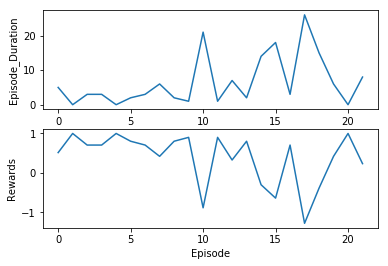

In [13]:
if __name__ == '__main__':
	
	env = img_env.ImgEnv('mnist', train=True, max_steps=200, channels=2, window=5)
	num_episodes = 200


	net = myNet(obs_shape=env.observation_space.shape, action_space=env.action_space, dataset='mnist')
	memory = ReplayMemory(10000)

	BATCH_SIZE = 32
	GAMMA = 0.99

	total_rewards = {}
	episode_durations = {}
	for i_episode in range(num_episodes):
		total_reward_i = 0
		observation = env.reset()
		curr_label = env.curr_label.item()
		for t in range(100): # allow 100 steps
			value, actionS, Q_values, clf_proba, action_log_probs, states = net.act(inputs=torch.from_numpy(observation).float().resize_(1, 2, 32, 32), \
				states=observation, masks=observation[1])
			action = actionS.numpy()[0][0]
			class_pred = actionS.numpy()[0][1]
			actionS = actionS.numpy()[0]
			last_observation = observation
			observation, reward, done, info = env.step(actionS)
			total_reward_i = reward + GAMMA*total_reward_i
			memory.push(torch.from_numpy(last_observation), torch.from_numpy(actionS), \
				torch.from_numpy(observation), torch.tensor([reward]).float(), torch.tensor([curr_label]))
			# print ('t = %i: action = %i, class = %i, class_pred = %i, reward = %f'%(t, action, curr_label, class_pred, reward))

			 # train action head every time

			if t % 5 == 0: # train clf head every 5 time steps
				# print ("=============also train clf====")
				optimize_myNet(net, curr_label, BATCH_SIZE, optimize_clf=True)
			else:
				optimize_myNet(net, curr_label, BATCH_SIZE, optimize_clf=False)

			if done:
				# print ('Done after %i steps'%(t+1))
				break

		if curr_label in total_rewards.keys():
			total_rewards[curr_label].append(total_reward_i)
			episode_durations[curr_label].append(t)
		else:
			total_rewards[curr_label] = [total_reward_i]
			episode_durations[curr_label] = [t]
		
	plt.title('Class 0')
	plt.subplot(2, 1, 1)
	plt.xlabel('Episode')
	plt.ylabel('Episode_Duration')
	durations_t = torch.tensor(episode_durations[0], dtype=torch.float)
	plt.plot(durations_t.numpy())

	plt.subplot(2, 1, 2)
	plt.xlabel('Episode')
	plt.ylabel('Rewards')
	total_rewards_t = torch.tensor(total_rewards[0], dtype=torch.float)
	plt.plot(total_rewards_t.numpy())
	plt.show()




In [20]:
total_rewards[0]

[-1.1748762178548304,
 -0.19222852862852857,
 1.0,
 1.0,
 0.20359161258740843,
 -0.6847812948549472,
 1.0,
 -0.2909363000999001,
 -1.9539463704177353,
 0.5014980014994002,
 0.9001,
 -0.19222852862852857,
 0.4020965034979007,
 -0.7829965135600923,
 0.5014980014994002,
 0.10448802097482102,
 0.8002999,
 0.5014980014994002,
 -0.3895453637998003,
 -4.254089739497303,
 1.0]